# Twitter Hate Speech Detection

## *Can Content Moderation Be Automated?*

![banner](./visualizations/banner.png)


# Overview

This project aims to **automate content moderation** to identify hate speech using **machine learning binary classification algorithms.** Baseline models included Random Forest, Naive Bayes, Logistic Regression and Support Vector Machine (SVM). The final model was a **Logistic Regression** model that used Count Vectorization for feature engineering. It produced an F1 of 0.3958 and Recall (TPR) of 0.624. This performance can be attributed to the massive class imbalance and the model's inability to "understand" the nuances of English slang and slurs. Ultimately, automating hate speech detection is an extremely difficult task. And although this project was able to get that process started, there is more work to be done in order to keep this content off of public-facing forums such as Twitter.

An **interactive version** of the final model is hosted on Heroku. Check it out [here](https://hate-speech-predictor.herokuapp.com/)!

# Business Problem

Human content moderation exploits people by consistently traumatizing and underpaying them. In 2019, an [article](https://www.theverge.com/2019/6/19/18681845/facebook-moderator-interviews-video-trauma-ptsd-cognizant-tampa) on The Verge exposed the extensive list of horrific working conditions that employees faced at Cognizant, Facebook’s former moderation contractor. Unfortunately, every major tech company, including Twitter, uses human moderators to some extent, both domestically and overseas.

Hate speech is defined as abusive or threatening speech that expresses prejudice against a particular group, especially on the basis of race, religion or sexual orientation. Usually, the difference between hate speech and offensive language comes down to subtle context or diction. 

Any company with an online forum where users post content could benefit from automating as much as the moderation process as possible. Ultimately, human content moderation is not only detrimental to workers, but also presents a liability to companies that use them.

**Warning:** This notebook contains offensive language from the dataset.

# Data & Methods

The dataset for this capstone project was sourced from a study called *Automated Hate Speech Detection and the Problem of Offensive Language* conducted by Thomas Davidson and a team at Cornell University in 2017. The GitHub repository can be found [here](https://github.com/t-davidson/hate-speech-and-offensive-language). The dataset is provided as a `.csv` file with 24,802 text posts from Twitter where **6% of the tweets were labeled as hate speech**. 

Since content moderation is so subjective, the labels on this dataset were voted on by crowdsource and determined by majority-rules. The “class” column labels each tweet as 0 for hate speech, 1 for offensive language or 2 for neither. In order to create a different project and adapt the data to my specific business context, I will be treating the data as a binary classification problem. 

Therefore, the final model will be **predicting whether a tweet is hate speech or not.** To prepare the data for this, I will be manually replacing existing 1 and 2 values as 0, and replacing 0 as 1 to indicate hate speech.

# Data Understanding

### 1. What are the linguistic differences between hate speech and offensive language?

![img1](./visualizations/label_word_count_y.png)

The code for this graph can be found in [`eda_notebook.ipynb`](https://github.com/sidneykung/twitter_hate_speech_detection/blob/master/preprocessing/eda_notebook.ipynb).

Linguistically, it's important to note that the difference between hate speech and offensive language often comes down to how it targets marginalized communities, often in threatening ways.

Although these graphs have very similar frequently occurring words, there are a few that stand out. For instance, we can notice from this figure that Hate Speech typically contains the N-word with the hard 'R'. **The use of this slur could indicate malicious intent, which goes beyond possibly using the word as slang.**

Examples like that one demonstrate the nuances of English slang and the fine line between Hate Speech and offensive language. **Because of the similarities of each label’s vocabulary, it could be difficult for machine learning algorithms to differentiate between them and determine what counts as Hate Speech.**

### 2. What are the most popular hashtags of each tweet type?

![img2](./visualizations/censored_top_hashtags.png)

The code for this graph can be found in [`censored_hashtags.ipynb`](https://github.com/sidneykung/twitter_hate_speech_detection/blob/master/preprocessing/censored_hashtags.ipynb).

From these word clouds, we can see some more parallels and differences between what is classified as hate speech or not. For instance, #tcot stands for "Top Conservatives On Twitter” and it appears in both groups. However, #teabagger, which refers to those who identify with the Tea Party, that is primarily (but not exclusively) associated with the Republican Party, appears in only the “Not Hate Speech” cloud. Both hashtags are used among Alt-Right communities.

Additionally, the #r**skins hashtag appears in only the "Not Hate Speech" cloud. This was the former name of the Washington NFL team. Knowing the context, we know that hashtag could certainly include text that constitutes as hate speech. With this, and other hashtags that appear in the “Not Hate Speech” cloud, we can clearly see the very slight differences between the two labels.

Besides that, others are simply pop culture references, such as #Scandal the TV show or #vote5sos referring to the boy band. It’s interesting that those contain a lot of offensive language, probably from fan reactions and community conflicts. Ultimately, we can recommend that **Twitter should closely monitor those top hashtags for potential posts containing hate speech** or even regular offensive language.


### 3. What is the overall polarity of the tweets?

![img3](./visualizations/compound_polarity_score.png)


The code for this graph can be found in [`VADER_sentiment.ipynb`](https://github.com/sidneykung/twitter_hate_speech_detection/blob/master/preprocessing/VADER_sentiment.ipynb).

The compound polarity score is a metric that calculates the sum of all the [lexicon ratings](https://github.com/cjhutto/vaderSentiment/blob/master/vaderSentiment/vader_lexicon.txt) which have been normalized between -1 and +1. With -1 being extreme negative and +1 being extreme positive. **This score encompasses the overall sentiment of this corpus.**

- Hate Speech tweets on average have a compound score of -0.363
- Non Hate Speech tweets on average have a compound score of -0.263

According to this metric, both classes of tweets have pretty negative sentiments because their normalized compound scores are less than the threshold of -0.05. 

Additionally from the graph above, we can see that tweets classified as Hate Speech are especially negative. This further emphasizes how slim the difference between the two labels are. Although both classes contain negative and offensive language, Hate Speech is much more negative on average.


![img3](./visualizations/avg_polarity_by_tweet_type.png)


The code for this graph can be found in [`VADER_sentiment.ipynb`](https://github.com/sidneykung/twitter_hate_speech_detection/blob/master/preprocessing/VADER_sentiment.ipynb).

To reiterate, this graph shows the average polarity scores for each label. Which are positive, neutral or negative. We can see that a majority were scored as neutral. However, of those that were scored as negative, it seems like "Not Hate Speech" had more on average. This is probably because of the class imbalance.

## Class Imbalance

The main roadblock of this dataset is the extreme class imbalance. We can see that only 5.77% of the data is labeled as hate speech. This could present challenges during the modeling process.

![imbalance](./visualizations/cleaned_class_imbalance.png)

The code for this graph can be found in [`data_cleaning.ipynb`](https://github.com/sidneykung/twitter_hate_speech_detection/blob/master/preprocessing/data_cleaning.ipynb).

***

In [176]:
# importing relevant libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
%matplotlib inline
plt.style.use('bmh')
import pickle
# custom fuctions
from src import helper_functions as helpers

# NLP libraries
import nltk
from sklearn.feature_extraction import text 
from nltk.stem import WordNetLemmatizer, PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

# modeling libraries
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks
from collections import Counter
from sklearn import metrics, utils, model_selection, svm
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, plot_confusion_matrix, classification_report

***

# Preprocessing Text Data

The original data from `twitter_data.csv` was cleaned using RegEx in the `data_cleaning.ipynb` notebook. 

**Cleaning Steps:**

- Reassigning labels
- Lowercasing tweet text
- Removing hashtags, mentions, quotes and punctuation from tweet text
- Checking for missing values

In [177]:
# loading in clean_df
clean_df = pd.read_pickle('./pickle/clean_df.pkl')

In [178]:
# previewing data
clean_df.head(3)

,total_votes,hate_speech_votes,other_votes,label,tweet,clean_tweets
0,3,0,3,0,!!! RT @mayasolovely: As a woman you shouldn't...,as a woman you shouldnt complain about clea...
1,3,0,3,0,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,boy dats coldtyga dwn bad for cuffin dat ho...
2,3,0,3,0,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,dawg you ever fuck a bitch and she sta to...


From here, we'll be focusing on the `clean_tweets` column and the target variable, `label`.

## Tokenizing & Removing Stop Words

When working with text data, one of the first steps is to remove stop words from the corpus. Although text would be gramatically incorrect without these stop words, they provide little value to models and typically hinder performace.

We can use NLTK's built-in library of stop words to remove them in a tokenizing function.

In [179]:
# assigning variables to essential columns
data = clean_df['clean_tweets']
target = clean_df['label']

In [180]:
# setting NLTK stop words as `stop_words`
stop_words = set(stopwords.words('english'))

Next, we can use the `process_tweet` helper function, which tokenizes all the text and removes stop words.

In [181]:
# applying the above function to our `clean_tweets`
processed_data = list(map(helpers.process_tweet, data))

In [182]:
# getting count of all unique words in the corpus
total_vocab = set()
for comment in processed_data:
    total_vocab.update(comment)
len(total_vocab)

20277

We can see that **the corpus has a vocabulary of 20,277 unique words**. This is useful to know because that will be the amount of columns in the sparse matrix after TF-IDF Vectorization. But we'll get to that step later.

## Top Words in Corpus

In [183]:
# transforming `processed_data` into a readable list
flat_filtered = [item for sublist in processed_data for item in sublist]
# getting frequency distribution
clean_corpus_freqdist = FreqDist(flat_filtered)
# top 20 words in cleaned corpus
clean_corpus_freqdist.most_common(20)

[('bitch', 8227),
 ('bitches', 3083),
 ('like', 2766),
 ('hoes', 2368),
 ('pussy', 2099),
 ('im', 2061),
 ('hoe', 1906),
 ('dont', 1749),
 ('got', 1597),
 ('ass', 1570),
 ('get', 1428),
 ('fuck', 1411),
 ('u', 1280),
 ('shit', 1262),
 ('nigga', 1198),
 ('aint', 1158),
 ('trash', 1142),
 ('lol', 1074),
 ('know', 806),
 ('niggas', 791)]

These top words are mostly offensive terms, and some other slang words that the NLTK stop words removal function didn't pick up.

For a breakdown of the top words in each label, refer to [`eda_notebook.ipynb'](https://github.com/sidneykung/twitter_hate_speech_detection/blob/master/preprocessing/eda_notebook.ipynb).

## Lemmatization

This last method reduces each word into a linguistically valid **lemma**, or **root word**. It does this through linguistic mappings, using the WordNet lexical database.


In [184]:
# creating a list with all lemmatized outputs
lemmatizer = WordNetLemmatizer() 
lemmatized_output = []

for listy in processed_data:
    lemmed = ' '.join([lemmatizer.lemmatize(w) for w in listy])
    lemmatized_output.append(lemmed)

In [185]:
X_lem = lemmatized_output
y_lem = target

Now `X_lem` and `y_lem` are contain cleaned text and the original labels, ready to be used for modeling.

# Feature Engineering

With Natural Language Processing, the purpose of feature engineering is to transform the tokenized text data into numerical vectors that the machine learning algorithm can "understand."

In this notebook, we'll be iterating through three different feature engineering techniques: **Count Vectorization, TF-IDF Vectorization and Doc2Vec**. Trying out these techniques could yield vastly different metrics on the same four baseline models.

## Train-Test Split
First, let's perform a train-test split of the dataset, where 20% is reserved as unseen testing data.

In [186]:
# initial TTS
X_train, X_test, y_train, y_test = train_test_split(X_lem, y_lem, test_size=0.20, random_state=15)

## TF-IDF Vectorization

First, we’ll be trying one of the most popular methods, TF-IDF Vectorization.

This is an acronym that stands for “Term Frequency — Inverse Document” Frequency which are the components of the resulting scores assigned to each word.
- Term Frequency: This summarizes how often a given word appears within a document.
- Inverse Document Frequency: This down scales words that appear a lot across documents.

Without going into the math, TF-IDF are word frequency scores that try to highlight words that are more interesting, e.g. frequent in a document but not across other documents.

In [187]:
# instantiating tf_idf vectorizer
tfidf = TfidfVectorizer(stop_words= stop_words, ngram_range=(1,2))

In [188]:
# transforming tokenized data into sparse matrix format with 20K stored elements
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

In [189]:
# taking a quick look at the non zero elements
non_zero_cols = X_train_tfidf.nnz / float(X_train_tfidf.shape[0])
print("Average Number of Non-Zero Elements in Vectorized Articles: {}".format(non_zero_cols))
percent_sparse = 1 - (non_zero_cols / float(X_train_tfidf.shape[1]))
print('Percentage of columns containing ZERO: {}'.format(percent_sparse))

Average Number of Non-Zero Elements in Vectorized Articles: 13.364420457984465
Percentage of columns containing ZERO: 0.9998720483637183


Here, we can see that 99.9% of the columns contain a zero, meaning that's a very **sparse matrix** with 20K columns. We know the amount of columns because it's the size of the total corpus vocabulary. Additionally, it seems that the average length of the individual tweets is 13 words.

***

# Modeling Process

## Evaluation Metrics

For this business problem, **we will use F1 score as the main metric**, while also looking at Precision and Recall. The F1 score finds the harmonic mean between Precision and Recall, and it's useful for data with high class imbalance.

**Overall, we want as much hate speech to flagged as possible** and so that it can be efficiently removed. This means also **optomizing the True Positive Rate**, aka Recall.

### Weighted F1 Score

We will also be looking at the weighted F1 score, as it **can account for the class imbalance in labels by calculating metrics for each label**. It finds their average weighted by support (the number of true instances for each label). This results in a F1 score that is not between precision and recall.

### Cross Validation

Additionally, in order to see **whether a model is overfit or underfit**, we can use K-Fold Cross Validation to generate a F1 score for the training set. 

This method uses a limited sample in order to estimate how the model is expected to perform when making predictions on unseen data. For each model, 'K" aka the number of folds will be 5. This means that the data sample will be split into 5 groups and each used as the test set.

# Baseline Modeling

In this section we'll be running baseline Randon Forest, Logistic Regression, Naive Bayes and Support Vector Machine (SVM) models. Out of those 4 models, the best performing one will be selected to iterate through to achieve an MVP.

## Baseline Random Forest

A random forest model is an ensamble method that uses multiple Decision Trees to try to predict the output variable. Typically, it's one of the best performing models for classification problems.

In [190]:
rf_baseline = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=0)

Note that adding `class_weight='balanced'` actually increaased precision, but decreased F1. We'll keep that hyperparameter in there, because it would need to be added eventually anyway, to deal with the huge class imbalance in this dataset.

⏳ the cell below takes about 38 seconds to run

In [191]:
%%time
rf_baseline.fit(X_train_tfidf, y_train)
rf_test_preds = rf_baseline.predict(X_test_tfidf)

CPU times: user 36.5 s, sys: 256 ms, total: 36.7 s
Wall time: 37 s


In [192]:
rf_precision = precision_score(y_test, rf_test_preds)
rf_recall = recall_score(y_test, rf_test_preds)
rf_f1_score = f1_score(y_test, rf_test_preds)
rf_f1_weighted = f1_score(y_test, rf_test_preds, average='weighted')

# printing scores
helpers.evaluation(rf_precision, rf_recall, rf_f1_score, rf_f1_weighted)

Testing Set Evaluation Metrics:
Precision: 0.4128
Recall: 0.1613
F1 Score: 0.232
Weighted F1 Score: 0.9272


These scores are not ideal becuase the F1 is being brought down on how the model predicts the "Hate Speech" label. The weighted F1 score mostly shows how the model is predicting the majority class, "Not Hate Speech". From here, we should try other baseline models to see if the uniform F1 can improve.

Additionally, as mentioned, we can take the cross validated F1 for the training set to determine whether each model is overfit or underfit.

⏳ the cell below takes about 9 minutes to run

In [193]:
%%time
# training f1
rf_f1_cv = cross_val_score(rf_baseline, X_train_tfidf, y_train, scoring='f1', cv=5)
rf_mean_cv = round(rf_f1_cv.mean(), 6)

CPU times: user 8min 27s, sys: 1.91 s, total: 8min 29s
Wall time: 8min 31s


In [194]:
# is this model overfit or underfit?
rf_fit = helpers.model_fit(rf_mean_cv, rf_f1_score)
rf_fit

'underfit'

### Overfit vs. Underfit

Above, I used a custom function to streamline the categorization process. For instance, when a model's training metrics are higher than its testing metrics, then it is overfit.

Generally, a slightly underfit model is preferred. This means that the model is not too specific to the training data, and it should be able to generalize well on unseen data.

We can continue to run this custom fuction on future iterations to determine each model's fit. We can also store all the testing set evaluation metrics for each model into a dictionary, and display them in a dataframe later for comparison.

In [195]:
# creating dictionary to store all metrics
metric_dict = {}
# adding scores to metric_dict
metric_dict['Baseline Random Forest - TFIDF'] = {'precision': rf_precision, 'recall': rf_recall, 'f1_score': rf_f1_score, 'weighted_f1': rf_f1_weighted, 'fit': rf_fit}

## Baseline Logistic Regression

Logistic Regression is another common model used for classification tasks. Additionally, this model tends to work better with larger datasets.

In [196]:
log_reg_baseline = LogisticRegression(penalty='l2', class_weight='balanced', random_state=20)
# class_weight='balanced' actually didn't impact the score

Here I added `class_weight='balanced'` again, but this actually didn't impact the score. So we'll keep that hyperparamter. Also note that the penality is set to `L2`, but that's already the default.

⏳ the cell below takes about 3 seconds to run

In [197]:
%%time
log_reg_baseline.fit(X_train_tfidf, y_train)
log_reg_test_preds = log_reg_baseline.predict(X_test_tfidf)

CPU times: user 3.1 s, sys: 560 ms, total: 3.66 s
Wall time: 2.05 s


In [198]:
log_reg_precision = precision_score(y_test, log_reg_test_preds)
log_reg_recall = recall_score(y_test, log_reg_test_preds)
log_reg_f1_score = f1_score(y_test, log_reg_test_preds)
log_reg_f1_weighted = f1_score(y_test, log_reg_test_preds, average='weighted')

# printing scores
helpers.evaluation(log_reg_precision, log_reg_recall, log_reg_f1_score, log_reg_f1_weighted)

Testing Set Evaluation Metrics:
Precision: 0.2939
Recall: 0.5699
F1 Score: 0.3878
Weighted F1 Score: 0.9134


Compared the the first Random Forest baseline, the Logistic Regression baseline performed much better. The F1 score increased from 0.232 to 0.3878.

Although, this F1 score could still be increased. Before deciding on the model to iterate on, let's try Naive Bayes and SVM baselines first.

⏳ the cell below takes about 13 seconds to run

In [199]:
%%time
# training f1
log_reg_f1_cv = cross_val_score(log_reg_baseline, X_train_tfidf, y_train, scoring='f1', cv=5)
log_reg_mean_cv = round(log_reg_f1_cv.mean(), 6)

CPU times: user 13.7 s, sys: 241 ms, total: 13.9 s
Wall time: 3.68 s


In [200]:
# is this model overfit or underfit?
log_reg_fit = helpers.model_fit(log_reg_mean_cv, log_reg_f1_score)
log_reg_fit

'overfit'

In [201]:
# adding scores to metric_dict
metric_dict['Baseline Log Reg - TFIDF'] = {'precision': log_reg_precision, 'recall': log_reg_recall, 'f1_score': log_reg_f1_score, 'weighted_f1': log_reg_f1_weighted, 'fit': log_reg_fit}

## Baseline Naive Bayes

This model is another common baseline classification algorithm that uses Bayes Theorem with an assumption of independence between predictors. However, this assumption of independence is usually violated because the predictors are typically correlated to each other. That's where the "Naive" comes from.

Naive Bayes is a popular choice for text classification because it classifies based on the probabilities of events. Another pro is that this model takes less time to train.

In [202]:
baseline_bayes = MultinomialNB(alpha = .01)

⏳ the cell below takes about 11 milliseconds to run

In [203]:
%%time
baseline_bayes.fit(X_train_tfidf, y_train)
bayes_test_preds = baseline_bayes.predict(X_test_tfidf)

CPU times: user 10.7 ms, sys: 11.9 ms, total: 22.5 ms
Wall time: 37.7 ms


In [204]:
bayes_precision = precision_score(y_test, bayes_test_preds)
bayes_recall = recall_score(y_test, bayes_test_preds)
bayes_f1_score = f1_score(y_test, bayes_test_preds)
bayes_f1_weighted = f1_score(y_test, bayes_test_preds, average='weighted')

# printing scores
helpers.evaluation(bayes_precision, bayes_recall, bayes_f1_score, bayes_f1_weighted)

Testing Set Evaluation Metrics:
Precision: 0.4118
Recall: 0.1254
F1 Score: 0.1923
Weighted F1 Score: 0.9255


The F1 score dropped down to .1923. So, this model performed worse than both the Random Forest and Logistic Regression models. This is surprising because Naive Bayes typically performs pretty well with text data. This could indicate that preprocessing steps could be improved.

For now, let's try the last baseline and decide which model to iterate on.

⏳ the cell below takes about 55 milliseconds to run

In [205]:
%%time
# training f1
bayes_f1_cv = cross_val_score(baseline_bayes, X_train_tfidf, y_train, scoring='f1', cv=5)
bayes_mean_cv = round(bayes_f1_cv.mean(), 6)

CPU times: user 57.8 ms, sys: 7.14 ms, total: 64.9 ms
Wall time: 64.4 ms


In [206]:
bayes_fit = helpers.model_fit(bayes_mean_cv, bayes_f1_score)
bayes_fit

'underfit'

In [207]:
# adding scores to metric_dict
metric_dict['Baseline Naive Bayes - TFIDF'] = {'precision': bayes_precision, 'recall': bayes_recall, 'f1_score': bayes_f1_score, 'weighted_f1': bayes_f1_weighted, 'fit': bayes_fit}

## Baseline Support Vector Machine (SVM)

An SVM is a type of classifier that modifies the loss function for optimization to not only take into account overall accuracy metrics of the resulting predictions, but also to maximize the decision boundary between the data points. Essentially, this further helps tune the classifier as a good balance between underfitting and overfitting.

A notable hyperparameter is the Kernel, which reprojects data onto a new parameter space using combinations of existing features. From there, the same process of applying SVMs to this transformed space can then be employed. This could provide more complex boundaries than just Linear.

For now, let's try an SVM with a Linear kernel as a baseline.

In [208]:
SVM_baseline = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto', class_weight='balanced')

Notice that you can also add `class_weight='balanced'` to SVM models. This can help preemptively deal with the huge class imbalance in this dataset.

⏳ the cell below takes about 1 minute to run

In [209]:
%%time 
# fit the training dataset on the classifier
SVM_baseline.fit(X_train_tfidf, y_train)
# predict the labels on validation dataset
SVM_test_preds = SVM_baseline.predict(X_test_tfidf)

CPU times: user 51 s, sys: 847 ms, total: 51.9 s
Wall time: 52.3 s


In [210]:
SVM_precision = precision_score(y_test, SVM_test_preds)
SVM_recall = recall_score(y_test, SVM_test_preds)
SVM_f1_score = f1_score(y_test, SVM_test_preds)
SVM_f1_weighted = f1_score(y_test, SVM_test_preds, average='weighted')

# printing scores
helpers.evaluation(SVM_precision, SVM_recall, SVM_f1_score, SVM_f1_weighted)

Testing Set Evaluation Metrics:
Precision: 0.3609
Recall: 0.4373
F1 Score: 0.3955
Weighted F1 Score: 0.9281


This model produced the highest F1 so far, with a score of .3955. Next, let's look at the performance of all baselines all together, and move forward with a single model to iterate on. 

⏳ the cell below takes about 3 minutes to run

In [211]:
%%time
# training f1
base_SVM_f1_cv = cross_val_score(SVM_baseline, X_train_tfidf, y_train, scoring='f1', cv=5)
base_SVM_mean_cv = round(base_SVM_f1_cv.mean(), 6)

CPU times: user 2min 26s, sys: 1.81 s, total: 2min 27s
Wall time: 2min 28s


In [212]:
# is this model overfit or underfit?
base_SVM_fit = helpers.model_fit(base_SVM_mean_cv, SVM_f1_score)
base_SVM_fit

'underfit'

In [213]:
# adding scores to metric_dict
metric_dict['Baseline SVM - TFIDF'] = {'precision': SVM_precision, 'recall': SVM_recall, 'f1_score': SVM_f1_score, 'weighted_f1': SVM_f1_weighted, 'fit': base_SVM_fit}

## Evaluation Metrics for All Baseline Models

In [214]:
# printing dict for testing set metrics
pd.DataFrame.from_dict(metric_dict, orient='index')

,precision,recall,f1_score,weighted_f1,fit
Baseline Random Forest - TFIDF,0.412844,0.161290,0.231959,0.927249,underfit
Baseline Log Reg - TFIDF,0.293900,0.569892,0.387805,0.913449,overfit
Baseline Naive Bayes - TFIDF,0.411765,0.125448,0.192308,0.925487,underfit
Baseline SVM - TFIDF,0.360947,0.437276,0.395462,0.928112,underfit


It's a pretty close call between the Logistic Regression and SVM baselines. But overall, the **Linear SVM model** performed the best across both uniform and weighted F1. However, there is still work to be done to bring that score up higher. 

Next, we'll try improving that model with other feature engineering techniques, class imbalance remedy methods and tuning hyperparameters with grid search.

***

## Alternative Feature Engineering Methods

In this section, we can experiment with Count Vectorization and Doc2Vec as they are different ways to represent the data in a format that the machine learning models can "understand."

## Doc2Vec

One disadvantage to using Count Vectorization or TF-DF Vectorization is that we can run into the Curse of Dimensionality, which occurs when the number of features explodes. This problem happens because these methods create Sparse Vectors, that are the length of the total vocabulary of the text corpus. 

This corpus has a vocabulary of 20,277. Therefore, that's the number of columns in the Sparse Matrix, creating a ton of extra space of 99% 0s could possibly hurt the model. 

We can try Doc2Vec feature engineering, which is an extension of Word2Vec. It aims to learn how to project a document into a latent d-dimensional space. Specifically, the Distributed Bag of Words (DBOW) model ignores the context words in the input, but instead forces the model to predict words randomly sampled from the paragraph in the output.

In [215]:
# fresh TTS for doc2vec data
doc_train, doc_test = train_test_split(clean_df, test_size=0.3, random_state=42)

### Data Preparation

After performing a fresh train test split of the original dataframe, the next step is tokenizing the text as usual. Again, we can do this with NLTK.

The lambda functions below will tokenize both the training and test set and tag each tweet with its label, "Hate Speech" or "Not Hate Speech."

In [216]:
# tagging training set
tagged_train = doc_train.apply(
    lambda r: TaggedDocument(words=helpers.tokenize_text(r['clean_tweets']), tags=[r.label]), axis=1)
# tagging testing set
tagged_test = doc_test.apply(
    lambda r: TaggedDocument(words=helpers.tokenize_text(r['clean_tweets']), tags=[r.label]), axis=1)

Let's take a look an example of a tagged tweet.

In [217]:
tagged_train.values[30]

TaggedDocument(words=['this', 'bitch', 'instating', 'and', 'driving', 'for', 'me'], tags=[0])

Here, you can see that this "Not Hate Speech" tweet has been tokenized and tagged with a `0` label.

### Training DBOW Model

As mentioned before, the Distributed Bag of Words (DBOW) model ignores the context words in the input, but instead forces the model to predict words randomly sampled from the paragraph in the output. It's similar to the Skip-gram model in Word2Vec. You can read more about the model in its documentation [here](https://radimrehurek.com/gensim/models/doc2vec.html).

The hyperparameters we'll use are as follows:
- `vector_size`: dimensionality of the feature vectors
- `alpha`: initial learning rate
- `min_count`: ignores all words with total frequency lower than this
- `dm`: defines the training algorithm; when dm=1, 'distributed memeory' (PV-DVM) is used
- `epochs`: number of iterations (epochs) over the corpus, defaults to 10 for Doc2Vec

In [218]:
# instantiating a doc2vec DBOW model
dbow_model = Doc2Vec(vector_size=100, 
                alpha=0.025, 
                min_count=5,
                dm=1, epochs=100)

In [219]:
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")

# building vocabulary 
dbow_model.build_vocab([x for x in tqdm(tagged_train.values)])

100%|██████████| 17348/17348 [00:00<00:00, 2955914.27it/s]


Now that we have built a vocabulary based on the training set, we can initialize the model and train it for 30 epochs.

⏳ the cell below takes about 26 seconds to run

In [220]:
%%time
for epoch in range(30):
    dbow_model.train(utils.shuffle([x for x in tqdm(tagged_train.values)]), total_examples=len(tagged_train.values), epochs=1)
    dbow_model.alpha -= 0.002
    dbow_model.min_alpha = dbow_model.alpha

100%|██████████| 17348/17348 [00:00<00:00, 2708157.88it/s]
CPU times: user 26.9 s, sys: 4.22 s, total: 31.1 s
Wall time: 23.4 s


## Applying Doc2Vec Data to Train Baseline Linear SVM

The custom function `vec_for_learning` simply transforms the tagged tweets into vectors that are suitable for classification model use.

In [221]:
# train-test split
doc_y_train, doc_X_train = helpers.vec_for_learning(dbow_model, tagged_train)
doc_y_test, doc_X_test = helpers.vec_for_learning(dbow_model, tagged_test)

Next, we feed the Doc2Vec data into the previous Linear SVM model to see how this method compares to TF-IDF Vectorization.

In [222]:
# instantiating new SVM model
Doc2Vec_SVM = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto', class_weight='balanced')

⏳ the cell below takes about 28 seconds to run

In [223]:
%%time
# fit the training dataset on the classifier
Doc2Vec_SVM.fit(doc_X_train, doc_y_train)

CPU times: user 26 s, sys: 276 ms, total: 26.3 s
Wall time: 26.4 s


SVC(class_weight='balanced', gamma='auto', kernel='linear')

In [224]:
# predict the labels on testing dataset
doc_SVM_y_preds = Doc2Vec_SVM.predict(doc_X_test)

In [225]:
doc_SVM_precision = precision_score(doc_y_test, doc_SVM_y_preds)
doc_SVM_recall = recall_score(doc_y_test, doc_SVM_y_preds)
doc_SVM_f1_score = f1_score(doc_y_test, doc_SVM_y_preds)
doc_SVM_f1_weighted = f1_score(doc_y_test, doc_SVM_y_preds, average='weighted')

# printing scores
helpers.evaluation(doc_SVM_precision, doc_SVM_recall, doc_SVM_f1_score, doc_SVM_f1_weighted)

Testing Set Evaluation Metrics:
Precision: 0.2051
Recall: 0.6347
F1 Score: 0.3101
Weighted F1 Score: 0.8737


Unfortunately, using this method did not produce a great F1 score. It seems that it wasn't even able to predict the "Not Hate Speech" label as well as the other top-performing baselines. Let's compare it with other baselines next.

⏳ the cell below takes about 2 minutes to run

In [226]:
%%time
# training f1
doc_SVM_f1_cv = cross_val_score(Doc2Vec_SVM, doc_X_train, doc_y_train, scoring='f1', cv=5)
doc_SVM_mean_cv = round(doc_SVM_f1_cv.mean(), 6)

CPU times: user 1min 35s, sys: 1.52 s, total: 1min 37s
Wall time: 1min 39s


In [227]:
# is this model overfit or underfit?
doc_SVM_fit = helpers.model_fit(doc_SVM_mean_cv, doc_SVM_f1_score)
doc_SVM_fit

'overfit'

Additionally, the Doc2Vec method produced an overfit model. Whereas the TF-IDF vectorization method on the same exact Linear SVM model produced an underfit model.

In [228]:
metric_dict['Baseline SVM - Doc2Vec'] = {'precision': doc_SVM_precision, 'recall': doc_SVM_recall, 'f1_score': doc_SVM_f1_score, 'weighted_f1': doc_SVM_f1_weighted, 'fit': doc_SVM_fit}

### Comparing with Other Models

In [229]:
# printing dict for testing set metrics
pd.DataFrame.from_dict(metric_dict, orient='index')

,precision,recall,f1_score,weighted_f1,fit
Baseline Random Forest - TFIDF,0.412844,0.161290,0.231959,0.927249,underfit
Baseline Log Reg - TFIDF,0.293900,0.569892,0.387805,0.913449,overfit
Baseline Naive Bayes - TFIDF,0.411765,0.125448,0.192308,0.925487,underfit
Baseline SVM - TFIDF,0.360947,0.437276,0.395462,0.928112,underfit
Baseline SVM - Doc2Vec,0.205148,0.634660,0.310069,0.873748,overfit


As I just mentioned, the Doc2Vec model didn't perform as well as the Baseline Logisitc Regression or Linear SVM with TF-IDF Vectorization. 

It's worth noting that **it was able to predict the positive label, "Hate Speech", the best out of all the other baseline models**. However, we are looking for a balance of a high recall and F1 scores. Therefore, the F1 score could still be improved.

Let's look at this closer with a classification report, to see how both SVM models predicted each label using the different vectorization methods.

### SVM Baselines: TF-IDF vs. Doc2Vec

In [230]:
target_names = ['class 0', 'class 1']
# Tf-IDF baseline
print('-'*14 + ' SVM Baseline with TF-IDF ' + '-'*13)
print(classification_report(y_test, SVM_test_preds, target_names=target_names))
# Doc2Vec baseline
print('-'*13 + ' SVM Baseline with Doc2Vec ' + '-'*13)
print(classification_report(doc_y_test, doc_SVM_y_preds, target_names=target_names))

-------------- SVM Baseline with TF-IDF -------------
              precision    recall  f1-score   support

     class 0       0.97      0.95      0.96      4678
     class 1       0.36      0.44      0.40       279

    accuracy                           0.92      4957
   macro avg       0.66      0.70      0.68      4957
weighted avg       0.93      0.92      0.93      4957

------------- SVM Baseline with Doc2Vec -------------
              precision    recall  f1-score   support

     class 0       0.97      0.85      0.91      7008
     class 1       0.21      0.63      0.31       427

    accuracy                           0.84      7435
   macro avg       0.59      0.74      0.61      7435
weighted avg       0.93      0.84      0.87      7435



As mentioned, the Doc2Vec was able to predict more of the positive class "Hate Speech" when it comes to Recall, but the F1 scores for each label are much lower than the TF-IDF vectorization method. Therefore, we won't proceed with this method. Instead, let's try the last feature engineering method, Count Vectorization.

***

## Count Vectorization

Count Vectorization is similar to TF-IDF Vectorization, but it simply counts the number of times each word appears in a document. Therefore, each individual tweet becomes a single vector where each element in the vector corresponds to the count of a unique word.

It's worth noting that when we vectorize text in this way, we lose the order that the sentences were in. This is known as the **Bag of Words** appraoch, because all of the tokenized words in the corpus are thrown into a "bag" of vectors for the model to "understand."

In [231]:
# fresh TTS
X_train, X_test, y_train, y_test = train_test_split(X_lem, y_lem, test_size=0.20, random_state=20)

In [232]:
# instantiating count vectorizer
count = CountVectorizer(stop_words=stop_words)

In [233]:
# fitting to the train and test set
X_train_count = count.fit_transform(X_train)
X_test_count = count.transform(X_test)

## Baseline Linear SVM with Count Vectorization

With TF-IDF Vectorization, the Linear SVM achieved an F1 of 0.3954. Let's see the Count Vectorization method for feature engineering can improve that score.

In [234]:
count_SVM = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto', class_weight='balanced')

⏳ the cell below takes about 23 seconds to run

In [235]:
%%time 
# fit the training dataset on the classifier
count_SVM.fit(X_train_count, y_train)
# predict the labels on validation dataset
count_SVM_test_preds = count_SVM.predict(X_test_count)

CPU times: user 22.9 s, sys: 486 ms, total: 23.3 s
Wall time: 24 s


In [271]:
count_SVM_precision = precision_score(y_test, count_SVM_test_preds)
count_SVM_recall = recall_score(y_test, count_SVM_test_preds)
count_SVM_f1_score = f1_score(y_test, count_SVM_test_preds)
count_SVM_f1_weighted = f1_score(y_test, count_SVM_test_preds, average='weighted')

# printing scores
helpers.evaluation(count_SVM_precision, count_SVM_recall, count_SVM_f1_score, count_SVM_f1_weighted)

Testing Set Evaluation Metrics:
Precision: 0.2712
Recall: 0.5365
F1 Score: 0.3603
Weighted F1 Score: 0.9104


Unfortunately this model did not achieve a higher F1 than the TF-IDF version of the SVM model. However, it does have a slightly higher Recall, bumping up from .437 to .5365. But as mentioned before, a balance between high recall and high F1 is important for this business context.

Additionally, I'm curious about how the other baseline models could perform with this method. We can try running the second-best baseline model, Logistic Regression, next.

⏳ the cell below takes about 2 minutes to run

In [237]:
%%time
# training f1
count_SVM_f1_cv = cross_val_score(count_SVM, doc_X_train, doc_y_train, scoring='f1', cv=5)
count_SVM_mean_cv = round(count_SVM_f1_cv.mean(), 6)

CPU times: user 1min 35s, sys: 1.55 s, total: 1min 36s
Wall time: 1min 37s


In [238]:
# is this model overfit or underfit?
count_SVM_fit = helpers.model_fit(doc_SVM_mean_cv, doc_SVM_f1_score)
count_SVM_fit

'overfit'

In [239]:
metric_dict['Baseline SVM - CountVectorizer'] = {'precision': count_SVM_precision, 'recall': count_SVM_recall, 'f1_score': count_SVM_f1_score, 'weighted_f1': count_SVM_f1_weighted, 'fit': count_SVM_fit}

## Baseline Logistic Regression with Count Vectorization

The initial Logistic Regression model using TF-IDF Vectorization achieved a decent F1 score of 0.3878. Additionally, that baseline actually had a higher F1 and recall than this recent Linear SVM with CountVectorization. Let's see if this new feature engineering method has an impact.

In [240]:
# instantiate model
count_log_reg_baseline = LogisticRegression(penalty='l2', class_weight='balanced', random_state=20)

⏳ the cell below takes about 1 second to run

In [241]:
%%time
count_log_reg_baseline.fit(X_train_count, y_train)
count_log_reg_test_preds = count_log_reg_baseline.predict(X_test_count)

CPU times: user 1.39 s, sys: 43.2 ms, total: 1.44 s
Wall time: 412 ms


In [242]:
count_log_reg_precision = precision_score(y_test, count_log_reg_test_preds)
count_log_reg_recall = recall_score(y_test, count_log_reg_test_preds)
count_log_reg_f1_score = f1_score(y_test, count_log_reg_test_preds)
count_log_reg_f1_weighted = f1_score(y_test, count_log_reg_test_preds, average='weighted')

# printing scores
helpers.evaluation(count_log_reg_precision, count_log_reg_recall, count_log_reg_f1_score, count_log_reg_f1_weighted)

Testing Set Evaluation Metrics:
Precision: 0.2898
Recall: 0.6241
F1 Score: 0.3958
Weighted F1 Score: 0.9121


Using Count Vectorization on the Logistic Regression baseline actually produced the highest F1 and Recall out of all the other models. It was able to achieve that "balance" that I was looking for before. Because although the Linear SVM with Doc2Vec had a higher Recall of 0.6346, its F1 was much lower at 0.31.

Ultimately, it looks like this model could be the final one. Before deciding, let's attempt some resampling methods, to see if the massive class imbalance can be handled better. Up until this point, the class imbalance has only been addressed by using the built-in `class_weight='balanced'` hyperparameter in each model.

⏳ the cell below takes about 3 seconds to run

In [243]:
%%time
# training f1
count_log_reg_f1_cv = cross_val_score(count_log_reg_baseline, doc_X_train, doc_y_train, scoring='f1', cv=5)
count_log_reg_mean_cv = round(count_log_reg_f1_cv.mean(), 6)

CPU times: user 3.9 s, sys: 76.6 ms, total: 3.98 s
Wall time: 1.07 s


In [244]:
# is this model overfit or underfit?
count_log_reg_fit = helpers.model_fit(count_log_reg_mean_cv, count_log_reg_f1_score)
count_log_reg_fit

'underfit'

Additionally, it's great that this model is underfit, meaning that it's not too specific to the training data. We can examine by how much later on.

In [245]:
metric_dict['Baseline Log Reg - CountVectorizer'] = {'precision': count_log_reg_precision, 'recall': count_log_reg_recall, 'f1_score': count_log_reg_f1_score, 'weighted_f1': count_log_reg_f1_weighted, 'fit': count_log_reg_fit}

***

# Dealing with Class Imbalance

The Logistic Regression model dealt with class imbalance with the parameter `class_weight='balanced'`. Let's try other class imbalance remedy methods to improve the baseline, before tuning hyperparameters with grid search.

## Over-Sampling with SMOTE
This method over-samples the minority class, "Hate Speech".

Rather than simply oversampling the minority class with replacement (which adds duplicate cases to the dataset), the algorithm generates new sample data by creating ‘synthetic’ examples that are combinations of the closest minority class cases.

After synthetically resampling our data, we no longer need to lean on penalized class weights in order to improve our model tuning.

![smote](./visualizations/smote.png)

In [273]:
# generating new sample data from original TF-IDF vectorized data
sm = SMOTE(random_state=40)
smote_X_train, smote_y_train = sm.fit_sample(X_train_count, y_train)

In [274]:
# feeding in best log reg model
smote_log_reg = LogisticRegression(penalty='l2', random_state=55)

⏳ the cell below takes about 1 second to run

In [275]:
%%time
smote_log_reg.fit(smote_X_train, smote_y_train)
smote_log_reg_test_preds = smote_log_reg.predict(X_test_count)

CPU times: user 1.9 s, sys: 80.2 ms, total: 1.98 s
Wall time: 629 ms


In [276]:
smote_precision = precision_score(y_test, smote_log_reg_test_preds)
smote_recall = recall_score(y_test, smote_log_reg_test_preds)
smote_f1_score = f1_score(y_test, smote_log_reg_test_preds)
smote_weighted_f1_score = f1_score(y_test, smote_log_reg_test_preds, average='weighted')

# printing scores
helpers.evaluation(smote_precision, smote_recall, smote_f1_score, smote_weighted_f1_score)

Testing Set Evaluation Metrics:
Precision: 0.2326
Recall: 0.4745
F1 Score: 0.3121
Weighted F1 Score: 0.9024


Seems that the uniform F1 score went down with SMOTE, from 0.3958 to 0.3121. It also had a lower Recall score. Let's see how the model performs with Tomek Links, where the majority is undersampled, instead.

⏳ the cell below takes about 8 seconds to run

In [277]:
%%time
# training f1
smote_f1_cv = cross_val_score(smote_log_reg, smote_X_train, smote_y_train, scoring='f1', cv=5)
smote_f1_mean_cv = round(smote_f1_cv.mean(), 6)

CPU times: user 8.49 s, sys: 168 ms, total: 8.66 s
Wall time: 2.36 s


In [278]:
# is this model overfit or underfit?
smote_fit = helpers.model_fit(smote_f1_mean_cv, smote_f1_score)
smote_fit

'overfit'

It's understandable that this model would be overfit. Because the minority class is being synthetically generated from existing data, so the training data becomes too specific.

In [280]:
# adding these metrics to evaluation metric dict
metric_dict['Log Reg Oversampled - CountVectorizer'] = {'precision': smote_precision, 'recall': smote_recall, 'f1_score': smote_f1_score, 'weighted_f1': smote_weighted_f1_score, 'fit': smote_fit}

## Under-Sampling with Tomek Links
This method under-samples the majoirty class, "Not Hate Speech."

Tomek links are pairs of very close instances, but of opposite classes. Removing the instances of the majority class of each pair increases the space between the two classes, facilitating the classification process.

![tomek](./visualizations/tomek_links.png)

In [281]:
# resampling original TF-IDF vectorized data
tl = TomekLinks()
tomek_X_train, tomek_y_train = tl.fit_resample(X_train_count, y_train)
print('Resampled dataset shape %s' % Counter(tomek_y_train))

Resampled dataset shape Counter({0: 18653, 1: 1156})


It only removed 22 values from the majority class. That doesn't seem like it would be very helpful, but let's take a look at the evaluation metrics.

In [282]:
tomek_log_reg = LogisticRegression(penalty='l2', random_state=55)

⏳ the cell below takes about 1 second to run

In [283]:
%%time
tomek_log_reg.fit(tomek_X_train, tomek_y_train)
tomek_log_reg_test_preds = tomek_log_reg.predict(X_test_count)

CPU times: user 1.15 s, sys: 29.4 ms, total: 1.18 s
Wall time: 350 ms


In [284]:
tomek_precision = precision_score(y_test, tomek_log_reg_test_preds)
tomek_recall = recall_score(y_test, tomek_log_reg_test_preds)
tomek_f1_score = f1_score(y_test, tomek_log_reg_test_preds)
tomek_weighted_f1_score = f1_score(y_test, tomek_log_reg_test_preds, average='weighted')

# printing scores
helpers.evaluation(tomek_precision, tomek_recall, tomek_f1_score, tomek_weighted_f1_score)

Testing Set Evaluation Metrics:
Precision: 0.5702
Recall: 0.2372
F1 Score: 0.3351
Weighted F1 Score: 0.9377


Although using Tomek Links performed better than using SMOTE, the resulting F1 still isn't as good as the initial Logistic Regression model's F1 score of 0.3958.

⏳ the cell below takes about 5 seconds to run

In [285]:
%%time
# training f1
tomek_f1_cv = cross_val_score(tomek_log_reg, tomek_X_train, tomek_y_train, scoring='f1', cv=5)
tomek_mean_cv = round(tomek_f1_cv.mean(), 6)

CPU times: user 5.06 s, sys: 1.12 s, total: 6.18 s
Wall time: 3.51 s


In [286]:
# is this model overfit or underfit?
tomek_fit = helpers.model_fit(tomek_mean_cv, tomek_f1_score)
tomek_fit

'underfit'

In [287]:
# adding these metrics to evaluation metric dict
metric_dict['Log Reg Undersampled - CountVectorizer'] = {'precision': tomek_precision, 'recall': tomek_recall, 'f1_score': tomek_f1_score, 'weighted_f1': tomek_weighted_f1_score, 'fit': tomek_fit}

***

# Grid Search

The `sklearn` library provides an easy way to tune model parameters through an exhuastive search using `GridSearchCV`. It combines K-Fold Cross Validation with a grid search of hyperparameters.

A full list of a Logistic Regression model's hyperparameters can be found in the documentation [here](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html).

With Logistic Regression models, however, there are not many hyperparameters to tune. In `post_MVP.ipynb`, I created a grid search to optomize the following hyperparameters:

- `Penality`: Used to specify the norm used in the penalization. The default is `L2`.
- `Solver`: Algorithm to use in the optimization problem.
- `C`: Inverse of regularization strength; must be a positive float. Like in support vector machines, smaller values specify stronger regularization.

Ultimately, the grid search tuned the hyperparameters as follows:

- {'C': 1.0, 'penalty': 'l2', 'solver': 'newton-cg'}

However, this model generated the exact same evaluation metrics as the initial Logistic Regression model that used CountVectorizer. Therefore, I decided not to include that grid search code or model in this notebook. As it didn't yield helpful results. Again, this could be attributed to the fact that there just aren't many hyperparameters to tune for this kind of model, so things usually dont change much.

***

# Evaluating All Models

In [290]:
# printing dict for testing set metrics
pd.DataFrame.from_dict(metric_dict, orient='index')

,precision,recall,f1_score,weighted_f1,fit
Baseline Random Forest - TFIDF,0.412844,0.161290,0.231959,0.927249,underfit
Baseline Log Reg - TFIDF,0.293900,0.569892,0.387805,0.913449,overfit
Baseline Naive Bayes - TFIDF,0.411765,0.125448,0.192308,0.925487,underfit
Baseline SVM - TFIDF,0.360947,0.437276,0.395462,0.928112,underfit
Baseline SVM - Doc2Vec,0.205148,0.634660,0.310069,0.873748,overfit
Baseline SVM - CountVectorizer,0.271218,0.536496,0.360294,0.910436,overfit
Baseline Log Reg - CountVectorizer,0.289831,0.624088,0.395833,0.912113,underfit
Log Reg Oversampled - CountVectorizer,0.232558,0.474453,0.312125,0.902366,overfit
Log Reg Undersampled - CountVectorizer,0.570175,0.237226,0.335052,0.937658,underfit


As mentioned before, the evaluation metrics between all of these iterations were very similar. But ideally, we were searching for a balance between a high Recall and high F1 score.

For instance, we can see that the baseline Linear SVM with Doc2Vec had the highest Recall, but a mediocre F1 score. Whereas the Logistic Regression model with CountVectorizer had a slightly lower Recall, but a much higher F1 score. Ultimately, this model will be the final model that we use.

Next, let's analyze the model's overall performance and how it applies to the business case.

***

# Final Model Analysis:
## Logisitic Regression with CountVectorizer

The best performing model is a Logistic Regression model using CountVectorizer for feature engineering. The hyperparameters were `penality=l2` and `class_weight='balanced'`.

## Pickling Final Model

This final model will be pickled for future use. For instance, the interactive webapp, hosted [here](https://hate-speech-predictor.herokuapp.com/) on Heroku!

In [264]:
pickle_out = open("./pickle/final_log_reg_count_model.pkl","wb")
pickle.dump(count_log_reg_baseline, pickle_out)
pickle_out.close()

## Evaluation Metrics for Testing Set

These scores give us a sense of how the model will perform on unseen data.

In [265]:
helpers.evaluation(count_log_reg_precision, count_log_reg_recall, count_log_reg_f1_score, count_log_reg_f1_weighted)

Testing Set Evaluation Metrics:
Precision: 0.2898
Recall: 0.6241
F1 Score: 0.3958
Weighted F1 Score: 0.9121


Ultimately, the uniform F1 score of .3958 is so low because it is brought down by the poor predicting ability for the "Hate Speech" label. This was seen in previous classification reports for this model.

We'll take a closer look at why that might be happening later, despite all the preprocessing steps and model iterations.

## Overfit or Underfit?

Although we already know that **this model is underfit**, Let's backtrack for a minute and **check by how much**.

In [272]:
# cross validated f1 score for training set
print('Training F1 Score: {:.5}'.format(count_log_reg_mean_cv))
# uniform f1 score for testing set
print('Testing F1 Score: {:.5}'.format(count_log_reg_f1_score))

Training F1 Score: 0.36497
Testing F1 Score: 0.39583


From this training metric, we can determine that the final model is only ** *slightly* underfit**.

Next, let's look at how the model was able to predict each label.

## Confusion Matrix

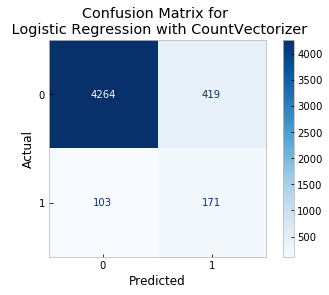

In [269]:
# generating standard confusion matrix
SVM_conf_matrix = plot_confusion_matrix(count_log_reg_baseline, X_test_count, y_test,
                                 display_labels=None,
                                 cmap=plt.cm.Blues)
SVM_conf_matrix.ax_.set_title('Confusion Matrix for \n Logistic Regression with CountVectorizer')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.grid(False)
plt.savefig('./visualizations/log_reg_count_matrix.png', bbox_inches = "tight", pad_inches=.5)
plt.show()

From this confusion matrix, we can see that the True Negative rate is high, but the True Positive rate is much lower. **Let's normalize these values to get a better sense of this relationship.**

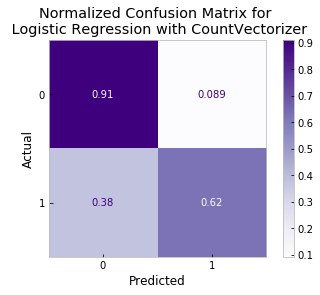

In [270]:
# generating normalized confusion matrix
SVM_conf_matrix = plot_confusion_matrix(count_log_reg_baseline, X_test_count, y_test,
                                 display_labels=None,
                                 cmap=plt.cm.Purples,
                                 normalize='true')
SVM_conf_matrix.ax_.set_title('Normalized Confusion Matrix for \n Logistic Regression with CountVectorizer')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.grid(False)
plt.savefig('./visualizations/normalized_log_reg_countvec_matrix.png', bbox_inches = "tight", pad_inches=.5)
plt.show()

So as expected, the final model has a True Negative Rate of 91% and a True Positive Rate of 62%.

This is consistent with the final model's evaluation metrics, where it got a Recall of .624, aka the True Positive Rate. In this business context, we would ideally want as many True Positives as possible, because that would be identifying Hate Speech correctly. Therefore, this is where the final model could be improved.

Also, we can see that only 8.9% of predictions are False Positives. Which mean that they were classified as "Hate Speech" when it's not. It's great that this amount is low, because site users tend to launch complaint reports when their content is over-flagged as hate speech content when it's not.

Overall, the Recall of this model needs to be greatly improved, in addition to the F1 of 0.3958.

***

# Conclusion

The final model had an F1 of .3958 and Recall of .624. Although this project had extensive preprocessing and modeling iterations, there is still room for improvement.

It's important to understand why the model performed poorly and how that relates to the business problem. The F1 score was brought down by the "Hate Speech" label predictions. The model was able to predict 91% of the "Not Hate Speech" labels correctly, but could only predict 62% other label. 

**This performance is indicative of the two major roadblocks of the project:** 

1. Massive class imbalance of the dataset
2. Model's inability to "understand" the nuances of hate speech

The issue of class imbalance is manageable with preprocessing techniques and oversampling/undersampling techniques. However, identifying hate speech is an overall problem that many major tech companies like Twitter, Facebook and Instagram are still struggling with.

This is because the line between Hate Speech and regular offensive language is so fine. Hate speech is defined as abusive or threatening speech that expresses prejudice against a particular group, especially on the basis of race, religion or sexual orientation. Usually, the difference between hate speech and offensive language comes down to subtle context or diction.

![venn](./visualizations/word_venn.png)

The code for this graph can be found in [`eda_notebook.ipynb`](https://github.com/sidneykung/twitter_hate_speech_detection/blob/master/preprocessing/eda_notebook.ipynb).

Here, we can see that there are **679 words unique to the "Hate Speech" label**. Some of these words are nonsensical or meaningless, but some are especially hateful terms. For example, this label contains phrases such as "sp-cs", "mo-kies", "ov-nj-w", "fa--ot" and much more. These are all ethnic or homophobic slurs. Most notably, we saw in earlier EDA that this label disproportionately contains the N-word with the hard "R". Language like this directly demonstrates hate speech by targeting marginalized groups.

However, it's hard for a machine learning model to understand the nuances with this hateful slang. **Although these words are unique to the "Hate Speech" label corpus, there's simply not enough data for that label.** Therefore, an important next step would be to collect more data that has been identified as hate speech by CrowFlower voters.

Additionally, we can recommend for now that Twitter **manually moderate tweets containing words**, just like it could with the top hashtags that were identified for each label in earlier EDA.

Ultimately, automating hate speech detection is an extremely difficult task because of the nuances in English slang and slurs. This project was able to get that process started, but there is much more work to be done to keep this content off of public-facing forums such as Twitter.

# Next Steps

To further develop this project, here are some immediate next steps that anyone could execute.

- Collect more potential "Hate Speech" data to be labeled by CrowdFlower voting system
- Improve final model with different preprocessing techniques, such as removing offensive language as stop words
- Evaluate model with new tweets or other online forum data to see if it can generalize well
- LDA Topic Modeling with Gensim